<a href="https://colab.research.google.com/github/gabrielnsil/risk_noncompliance/blob/main/Avalia%C3%A7%C3%A3o_de_Risco_de_Inadimpl%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avaliação de Risco de Inadimplência** 

#### **Introdução**

Após a junção das tabelas e começo do processo de tratamento de dados usando SQL, partimos para a próxima etapa do projeto que consiste em construir um modelo de **Machine Learning** (um estimador/classificador) com a capacidade de predizer de acordo com os dados bancários de um indivíduo, se ele pode ou não se tornar inadimplente. 

#### **Importando bibliotecas e os dados**

O conjunto de dados ("*data_noncomplianceRisk.csv*") oriundo do processo de tratamento inicial feito em SQL pode ser encontrado no meu github

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

### Tratamento e  balanceamento de Dataset
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

### Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
uri = 'https://raw.githubusercontent.com/gabrielnsil/risk_noncompliance/main/data_noncomplianceRisk.csv'
dados = pd.read_csv(uri)

In [3]:
dados.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,28,43200.0,Rent,1.0,Medical,A,3000.0,7.49,0.0,0.07,N,9
1,26,38340.0,Mortgage,7.0,Personal,B,2500.0,12.18,1.0,0.07,N,4
2,26,80000.0,Rent,0.0,Homeimprovement,A,8000.0,5.99,0.0,0.10,N,2
3,34,25200.0,Rent,NaN,Venture,A,3000.0,7.66,0.0,0.12,N,8
4,28,81972.0,Rent,4.0,Debtconsolidation,B,18000.0,10.99,0.0,0.22,N,6


#### **Tradução do nome das colunas**

Para facilitar a compreensão podemos traduzir os nomes das variáveis para simplificar ainda mais. Para isso, usamos um dicionário e o método `.rename`

In [4]:
mapa = {
    "person_age":"idade_pessoa",
    "person_income":"renda",
    "person_home_ownership":"tipo_moradia",
    "person_emp_length":"tempo_trabalhado",
    "loan_intent":"motivo_emprestimo",
    "loan_grade":"pontuacao_emprestimo",
    "loan_amnt":"valor_emprestimo",
    "loan_int_rate":"taxa_juros",
    "loan_status":"inadimplencia",
    "loan_percent_income":"renda_percentual_emprestimo",
    "cb_person_default_on_file":"devendo",
    "cb_person_cred_hist_length":"tempo_de_credito",
}

In [5]:
dados = dados.rename(mapa, axis = 1)

#### **Análise inicial dos dados**

Na maioria dos conjuntos de dados há informação inconsistentes que podem alterar ou confundir nossas interpretações. Aqui iremos procurar por outliers e dados nulos que possam prejudicar os modelos de Machine Learning que iremos utilizar.

---

A primeira etapa é utilizar `info()` para identificar a presença de valores nulos nas variáveis.

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34165 entries, 0 to 34164
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade_pessoa                 34165 non-null  int64  
 1   renda                        33866 non-null  float64
 2   tipo_moradia                 33862 non-null  object 
 3   tempo_trabalhado             32952 non-null  float64
 4   motivo_emprestimo            33878 non-null  object 
 5   pontuacao_emprestimo         33879 non-null  object 
 6   valor_emprestimo             33866 non-null  float64
 7   taxa_juros                   30596 non-null  float64
 8   inadimplencia                33853 non-null  float64
 9   renda_percentual_emprestimo  33877 non-null  float64
 10  devendo                      33836 non-null  object 
 11  tempo_de_credito             34165 non-null  int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 3.1+ MB


Disso, podemos constatar que:

*  O conjunto de dados possue 12 colunas e 34165 entradas de valores.
* Todas as 12 colunas **possuem valores nulos**
*   Algumas variáveis com dtype `object`não podem ser utilizadas nos modelos de ML sem um tratamento:
    * `situacao_moraria`
    * `motivo_emprestimo`
    * `pontuacao_emprestimo`
    * `devendo` 

----

Usando o método `describe()` podemos compreender melhor algumas características das variáveis numéricas, o que é bom para identificar valores discrepantes (outliers).

In [7]:
dados.describe()

,idade_pessoa,renda,tempo_trabalhado,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,tempo_de_credito
count,34165.000000,3.386600e+04,32952.000000,33866.000000,30596.000000,33853.000000,33877.000000,34165.000000
mean,27.730806,6.601223e+04,4.787964,9587.026812,11.012763,0.218149,0.170261,5.804947
std,6.346158,6.154345e+04,4.139394,6320.764123,3.240257,0.412995,0.106851,4.057528
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.840500e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.905000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Duas das variáveis `idade`e `tempo_trabalhado`possuem problemas visíveis:

* uma pessoa tem uma idade de **144 anos**, o que é altamente improvável
* outra possue tempo trabalhado de **123 anos**, igualmente improvável


---

Também é importante checar os valores únicos das variáveis categóricas. A identificação de `NULL` values é importante nessa etapa. Assim como saber a quantididade de categorias de cada variável.


In [8]:
dados.columns

Index(['idade_pessoa', 'renda', 'tipo_moradia', 'tempo_trabalhado',
       'motivo_emprestimo', 'pontuacao_emprestimo', 'valor_emprestimo',
       'taxa_juros', 'inadimplencia', 'renda_percentual_emprestimo', 'devendo',
       'tempo_de_credito'],
      dtype='object')

In [9]:
print(f'Tipo de Moradia: {dados["tipo_moradia"].unique()}')

Tipo de Moradia: ['Rent' 'Mortgage' 'Own' nan 'Other']


In [10]:
print(f'Motivo do Empréstimo: {dados["motivo_emprestimo"].unique()}')

Motivo do Empréstimo: ['Medical' 'Personal' 'Homeimprovement' 'Venture' 'Debtconsolidation'
 'Education' nan]


In [11]:
print(f'Pontuação Empréstimo: {dados["pontuacao_emprestimo"].unique()}')

Pontuação Empréstimo: ['A' 'B' 'D' 'C' 'E' nan 'G' 'F']


In [12]:
print(f'É uma pessoa com histórico de inadimplência?: {dados["devendo"].unique()}')

É uma pessoa com histórico de inadimplência?: ['N' 'Y' nan]




*   Podemos observar que todas as colunas categóricas possuem dados `NaN` ou nulos. Esses valores nulos deverão ser removidos do dataset.
*   Somente a variável `devendo` que aponta o histórico de inadimplência de uma pessoa possue categorias binárias (Y ou N) que deverão ser substituídos por 0 e 1.
*   As demais variáveis `tipo_moradia`, `motivo_emprestimo` e `pontuacao_emprestimo`também deverão ser trabalhadas. Aqui é possível aplicar um método chamado **one-hot-encoding** para ajustar isso.


Importante também é verificar o balanceamento da variável `inadimplencia:

In [13]:
dados["inadimplencia"].value_counts(normalize = True)

0.0    0.781851
1.0    0.218149
Name: inadimplencia, dtype: float64

Nota-se que essa variável está desbalanceada. Isso pode causar sérios problemas na etapa de treino do nosso modelo. Entretanto, podemos usar alguns métodos e procedimentos da biblioteca `sklearn` para isso.

### **Limpeza dos Dados**

Tendo uma primeira compreensão do nosso dataset, podemos iniciar o processo de limpeda dos dados.

Considerando que vamos remover os dados nulos, precisamos ter uma noção de quanta informação iremos perder nesse processo.

In [14]:
print(f'Quantidade de registros: {dados.shape[0]}')

Quantidade de registros: 34165


In [15]:
dados.isna().sum()

idade_pessoa                      0
renda                           299
tipo_moradia                    303
tempo_trabalhado               1213
motivo_emprestimo               287
pontuacao_emprestimo            286
valor_emprestimo                299
taxa_juros                     3569
inadimplencia                   312
renda_percentual_emprestimo     288
devendo                         329
tempo_de_credito                  0
dtype: int64

Como foi feito um pré-tratamento de dados ainda no SQL, temos uma quantidade bem reduzida de valores nulos. Julgo que a perda de informação nesse caso é muito pouca considerando o ganho de agilidade.

In [16]:
dados = dados.dropna()

In [17]:
print(f'Quantidade de registros após exclusão de valores nulos: {dados.shape[0]}')

Quantidade de registros após exclusão de valores nulos: 28638


In [18]:
print(f'Foram removidos um total de {34501-dados.shape[0]} registros do dataset original')

Foram removidos um total de 5863 registros do dataset original


Agora precisamos verificar e remover os dados que estão discrepantes. Podemos usar query para facilitar nossas buscas.

In [19]:
dados.query('idade_pessoa > 110')

,idade_pessoa,renda,tipo_moradia,tempo_trabalhado,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
13728,144,6000000.0,Mortgage,12.0,Personal,C,5000.0,12.73,0.0,0.00,N,25
17114,123,80004.0,Rent,2.0,Education,B,20400.0,10.25,0.0,0.25,N,3
21914,144,200000.0,Mortgage,4.0,Education,B,6000.0,11.86,0.0,0.03,N,2
28954,144,250000.0,Rent,4.0,Venture,C,4800.0,13.57,0.0,0.02,N,3


In [20]:
dados.query('tempo_trabalhado > 110')

,idade_pessoa,renda,tipo_moradia,tempo_trabalhado,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
8120,22,59000.0,Rent,123.0,Personal,D,35000.0,16.02,1.0,0.59,Y,3
20970,21,192000.0,Mortgage,123.0,Venture,A,20000.0,6.54,0.0,0.10,N,4


In [21]:
dados = dados.query('idade_pessoa < 110 & tempo_trabalhado < 100')


Também devemos alterar o tipo da variável `tempo_trabalhado` para o tipo inteiro (int64).

In [22]:
dados.loc[:, "tempo_trabalhado"] = dados.loc[:, "tempo_trabalhado"].astype(np.int64) # usando o .loc evitamos o warning de usar dados['tempo_trabalho'] = dados['tempo_trabalho'].astype(np.int64)
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28632 entries, 0 to 34164
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade_pessoa                 28632 non-null  int64  
 1   renda                        28632 non-null  float64
 2   tipo_moradia                 28632 non-null  object 
 3   tempo_trabalhado             28632 non-null  int64  
 4   motivo_emprestimo            28632 non-null  object 
 5   pontuacao_emprestimo         28632 non-null  object 
 6   valor_emprestimo             28632 non-null  float64
 7   taxa_juros                   28632 non-null  float64
 8   inadimplencia                28632 non-null  float64
 9   renda_percentual_emprestimo  28632 non-null  float64
 10  devendo                      28632 non-null  object 
 11  tempo_de_credito             28632 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 2.8+ MB


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### **Tratamento de dados**

Tendo executado todas as etapas até agora, é necessário realizar o tratamento dos dados para que eles possam ser usados na etapa de modelagem.

---

As variáveis categóricas deverão ser transformadas em variáveis *dummy* enquanto as numéricas serão normalizadas para ficarem em uma mesma escala, evitando problemas de balanceamento.

Um ponto importante é verificar quais variáveis numéricas estão correlacionadas de maneira positiva ou negativa.

In [23]:
dados.corr()

,idade_pessoa,renda,tempo_trabalhado,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,tempo_de_credito
idade_pessoa,1.000000,0.141471,0.176054,0.056061,0.010370,-0.022498,-0.039476,0.877581
renda,0.141471,1.000000,0.160952,0.324766,-0.003767,-0.167028,-0.297635,0.122787
tempo_trabalhado,0.176054,0.160952,1.000000,0.108390,-0.058263,-0.086486,-0.060099,0.151571
valor_emprestimo,0.056061,0.324766,0.108390,1.000000,0.145895,0.113363,0.577197,0.045580
taxa_juros,0.010370,-0.003767,-0.058263,0.145895,1.000000,0.339307,0.123401,0.015330
inadimplencia,-0.022498,-0.167028,-0.086486,0.113363,0.339307,1.000000,0.379534,-0.015575
renda_percentual_emprestimo,-0.039476,-0.297635,-0.060099,0.577197,0.123401,0.379534,1.000000,-0.029814
tempo_de_credito,0.877581,0.122787,0.151571,0.045580,0.015330,-0.015575,-0.029814,1.000000


É visível a forte correlação (0.877) entre `idade_pessoa` e `tempo_de_credito`, o que é algo esperado. Há também uma correlação considerável entre `renda_percentual_emprestimo` e `valor_emprestimo`. Nota-se que essa variável é calculada a partir das variáveis `renda`e `valor_emprestimo` e pode ser removida para evitar duplicatas.

In [24]:
dados2 = dados.drop("renda_percentual_emprestimo", axis = 1)

Para o procedimento de transformação das variáveis categóricas binárias (`devendo`) criaremos um dictionary.

In [25]:
dict = { 
    "Y" : 1,
    "N" : 0
}

In [26]:
dados2 = dados2.replace(dict)

In [27]:
dados2.head()

,idade_pessoa,renda,tipo_moradia,tempo_trabalhado,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,devendo,tempo_de_credito
0,28,43200.0,Rent,1,Medical,A,3000.0,7.49,0.0,0,9
1,26,38340.0,Mortgage,7,Personal,B,2500.0,12.18,1.0,0,4
2,26,80000.0,Rent,0,Homeimprovement,A,8000.0,5.99,0.0,0,2
4,28,81972.0,Rent,4,Debtconsolidation,B,18000.0,10.99,0.0,0,6
5,31,78000.0,Rent,1,Education,A,14000.0,9.63,0.0,0,5


Precisamos separar o dataset em duas partes:

1. a **variável alvo ou y**, que no caso é `inadimplencia`
2. demais variáveis que compõem o conjunto de **variáveis explicativas**

In [28]:
x = dados2.drop("inadimplencia", axis = 1)
y = dados2["inadimplencia"]

#### **One-hot-encoding**

Todas as demais variáveis categóricas explicativas com mais de duas categorias precisam passar por um novo procedimento para serem usadas no nosso modelo. Para isso é necessário construir **novas colunas**. Cada uma dessas novas colunas remete a uma variável e irá assumir valores `integer`

---

Para isso usamos uma classe derivada do `sklearn` chamada `OneHotEncoder`

In [29]:
dados2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28632 entries, 0 to 34164
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   idade_pessoa          28632 non-null  int64  
 1   renda                 28632 non-null  float64
 2   tipo_moradia          28632 non-null  object 
 3   tempo_trabalhado      28632 non-null  int64  
 4   motivo_emprestimo     28632 non-null  object 
 5   pontuacao_emprestimo  28632 non-null  object 
 6   valor_emprestimo      28632 non-null  float64
 7   taxa_juros            28632 non-null  float64
 8   inadimplencia         28632 non-null  float64
 9   devendo               28632 non-null  int64  
 10  tempo_de_credito      28632 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 2.6+ MB


In [30]:
var_categoricas = ["tipo_moradia", "motivo_emprestimo", "pontuacao_emprestimo" ]

one_hot_enc = make_column_transformer(
    (OneHotEncoder(), var_categoricas),
    remainder='passthrough'
)

dados_transformados = one_hot_enc.fit_transform(x)
dados_transformados = pd.DataFrame(dados_transformados, columns=one_hot_enc.get_feature_names_out())
dados_transformados.head()

,onehotencoder__tipo_moradia_Mortgage,onehotencoder__tipo_moradia_Other,onehotencoder__tipo_moradia_Own,onehotencoder__tipo_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade_pessoa,remainder__renda,remainder__tempo_trabalhado,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,28.0,43200.0,1.0,3000.0,7.49,0.0,9.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,26.0,38340.0,7.0,2500.0,12.18,0.0,4.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.0,80000.0,0.0,8000.0,5.99,0.0,2.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,28.0,81972.0,4.0,18000.0,10.99,0.0,6.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,31.0,78000.0,1.0,14000.0,9.63,0.0,5.0


#### **Normalização dos dados**

Lembrando que a escala das variáveis numéricas desse conjunto de dados é muito diferente. Isso pode gerar um viés no modelo de ML a ser utilizado levando a falsas conclusões. Desse modo, devemos normalizar os dados antes.


In [37]:
scaler = MinMaxScaler()

In [38]:
scaler.fit(dados_transformados)

MinMaxScaler()

In [39]:
dados_transformados = scaler.transform(dados_transformados) # criação de um array, devemos transformar em um dataframe

In [43]:
dados_transformados = pd.DataFrame(dados_transformados, columns = one_hot_enc.get_feature_names_out())
dados_transformados

,onehotencoder__tipo_moradia_Mortgage,onehotencoder__tipo_moradia_Other,onehotencoder__tipo_moradia_Own,onehotencoder__tipo_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade_pessoa,remainder__renda,remainder__tempo_trabalhado,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.125000,0.019255,0.024390,0.072464,0.116292,0.0,0.250000
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.093750,0.016868,0.170732,0.057971,0.379775,0.0,0.071429
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.093750,0.037332,0.000000,0.217391,0.032022,0.0,0.000000
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.125000,0.038301,0.097561,0.507246,0.312921,0.0,0.142857
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.171875,0.036350,0.024390,0.391304,0.236517,0.0,0.107143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28627,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.625000,0.016308,0.048780,0.275362,0.062921,0.0,0.892857
28628,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.031250,0.012182,0.146341,0.217391,0.341011,0.0,0.000000
28629,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.109375,0.017487,0.268293,0.124638,0.075281,0.0,0.250000
28630,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.156250,0.017682,0.195122,0.275362,0.410674,0.0,0.142857


### **Separação de dados (Treino e Teste)**

É importantíssimo, para a validação do modelo, saber como ele está performando. Para isso devemos dividir nosso dataset em 2 conjuntos: um de treinamento e outro de teste.

In [31]:
SEED = 144

In [32]:
treino_x, teste_x, treino_y, teste_y = train_test_split(dados_transformados, y, random_state = SEED, stratify = y)

In [33]:
print(f'Treinaremos nosso modelo com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos')

Treinaremos nosso modelo com 21474 elementos e testaremos com 7158 elementos


Para avaliar se `y_treino`está estratificado ou não:

In [34]:
# devemos também avaliar a proporçao de zeros e uns

print(f' Número de 0/1 no treino_x: \n{treino_y.value_counts()} \n \nNúmero de 0/1 no teste_x: \n{teste_y.value_counts()}')

 Número de 0/1 no treino_x: 
0.0    16823
1.0     4651
Name: inadimplencia, dtype: int64 
 
Número de 0/1 no teste_x: 
0.0    5607
1.0    1551
Name: inadimplencia, dtype: int64


In [35]:
treino_y

30231    1.0
25295    0.0
29865    0.0
5663     0.0
29335    0.0
        ... 
8439     1.0
16164    0.0
28797    0.0
25498    0.0
32969    0.0
Name: inadimplencia, Length: 21474, dtype: float64

### **Aprendizado Supervisionado: A escolha dos modelos**

Para realizarmos a predição de clientes inadimplentes é necessário escolher o melhor modelo para essa tarefa.

Para isso podemos aplicar duas técnicas de balanceamento:

1) **Oversampling**:

2) **Undersampling**:

Além disso podemos aplicar três algoritmos principais, que foram escolhidos dada a sua *explicabilidade*:

I. **Árvores de Decisão**

II. **Gradient Boosting**

III. **Regressão Logística** 


Nesse caso a métrica que iremos olhar será o **recall**, ou seja, nesse contexto é a proporção de clientes que são inadimplentes mas o modelo não detectou. Algo que pode gerar um grande prejuízo para a empresa.

### **Aprendizado Oversampling**

Usando o método para balanceamento **oversampling**, escolhemos a implementação SMOTE para realizar esse balanceamento da variável `inadimplencia`. Aqui iremos construir dados sintéticos da categoria com menos frequência.


In [52]:
smote = SMOTE(random_state = SEED)
x_balanceado_oversampling, y_balanceado_oversampling = smote.fit_resample(treino_x, treino_y)
x_balanceado_oversampling

,onehotencoder__tipo_moradia_Mortgage,onehotencoder__tipo_moradia_Other,onehotencoder__tipo_moradia_Own,onehotencoder__tipo_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade_pessoa,remainder__renda,remainder__tempo_trabalhado,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,24.000000,34400.000000,8.000000,14000.000000,16.000000,1.000000,3.000000
1,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,26.000000,60000.000000,3.000000,30000.000000,14.270000,0.000000,4.000000
2,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,0.000000,0.0,0.0,33.000000,65000.000000,4.000000,10000.000000,11.990000,0.000000,9.000000
3,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,0.000000,0.0,0.0,26.000000,80000.000000,5.000000,3000.000000,8.000000,0.000000,4.000000
4,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.0,0.0,30.000000,38000.000000,3.000000,8875.000000,16.890000,0.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33641,0.314275,0.0,0.0,0.685725,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,0.000000,0.0,0.0,21.314275,16029.541889,4.057174,5842.862291,8.847454,0.000000,3.000000
33642,0.771605,0.0,0.0,0.228395,0.000000,0.228395,0.000000,0.771605,0.0,0.000000,...,0.000000,0.0,0.0,24.598767,49000.000000,8.370372,5000.000000,14.189073,0.000000,3.827163
33643,0.853368,0.0,0.0,0.146632,0.146632,0.000000,0.000000,0.853368,0.0,0.000000,...,0.000000,0.0,0.0,26.120208,31956.010423,0.000000,7456.010423,11.607596,0.853368,8.266840
33644,0.000000,0.0,0.0,1.000000,0.347351,0.000000,0.000000,0.652649,0.0,0.000000,...,0.347351,0.0,0.0,26.736754,19858.354947,6.915895,3755.256578,16.345576,0.000000,4.431456


**I. DecisionTreeclassifier**



In [55]:
arvore = DecisionTreeClassifier(random_state= SEED)
arvore.fit(x_balanceado_oversampling, y_balanceado_oversampling)
previsao_arvore = arvore.predict(teste_x)

print(classification_report(teste_y, previsao_arvore))

              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      5607
         1.0       0.72      0.77      0.74      1551

    accuracy                           0.88      7158
   macro avg       0.83      0.84      0.83      7158
weighted avg       0.89      0.88      0.89      7158



In [58]:
heatmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["#12239e","#92dfa6","#9cd33b"])

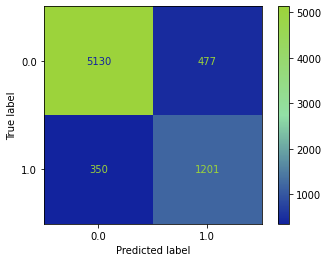

In [61]:
ConfusionMatrixDisplay.from_estimator(arvore, teste_x, teste_y, cmap = heatmap)
plt.grid(False)
plt.show()